# SARIMA (SARIMAX) Modeling for Cherry Blossom Bloom Day

This notebook fits a SARIMAX model to the cherry blossom dataset using the same train/validation/test splitting and evaluation used in the OLS notebook. It includes performance metrics (RMSE, MAE, WMAPE) and a plot showing actuals since 1921 with forecasts from 2016 onward.


## Plan and assumptions

- Use the same numeric predictors as in `stat_ols.ipynb` as exogenous regressors.
- Use years 1921–2015 as the pool for training/validation and perform a sequential 80/20 split (train/validation) to preserve temporal order.
- Reserve 2016–2025 as the test set.
- Fit a simple SARIMAX model (ARIMA-like) with exogenous variables. Because the data are annual, seasonal components are not required by default (seasonal_order=(0,0,0,0)). If you'd like automatic order selection, we can add that later.
- Metrics reported: RMSE, MAE, WMAPE (sum(|error|) / sum(|actual|)).


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_theme(style='whitegrid')


## 1) Load data

In [3]:
DATA_PATH = '../data/cherry_blossom_data.csv'
df = pd.read_csv(DATA_PATH)
print('Loaded rows:', len(df))
df.head()


Loaded rows: 107


,year,days_dec_ge_45,days_jan_ge_45,days_feb_ge_45,prec_winter,mean_temp_winter,surface_temp_chg,climate_incidents,bloom_day
0,1921,30,24,23,3.41,42.8,-0.05,3,79
1,1922,20,17,19,2.56,39.1,-0.12,2,97
2,1923,18,15,14,3.12,36.4,-0.18,1,99
3,1924,25,22,25,3.68,43.2,-0.09,4,104
4,1925,16,12,14,2.89,36.8,-0.14,2,86


## 2) Prepare features and target (same as OLS)

In [4]:
numeric_cols = ['days_dec_ge_45','days_jan_ge_45','days_feb_ge_45','prec_winter',
                'mean_temp_winter','surface_temp_chg','climate_incidents']
for c in numeric_cols + ['bloom_day','year']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing essential values
df = df.dropna(subset=['year','bloom_day'] + numeric_cols).reset_index(drop=True)

FEATURES = numeric_cols
TARGET = 'bloom_day'


## 3) Create train / validation / test splits (sequential)

In [5]:
train_val_df = df[(df['year'] >= 1921) & (df['year'] <= 2015)].sort_values('year').reset_index(drop=True)
# Test set: 2016-2025
test_df = df[(df['year'] >= 2016) & (df['year'] <= 2025)].sort_values('year').reset_index(drop=True)

print(f'Train/Val rows: {len(train_val_df)}, Test rows: {len(test_df)}')

n = len(train_val_df)
if n == 0:
    raise ValueError('No data in 1921-2015 range to train/validate on.')
train_n = int(np.floor(n * 0.8))
train_df = train_val_df.iloc[:train_n].reset_index(drop=True)
val_df = train_val_df.iloc[train_n:].reset_index(drop=True)

print(f'Train rows: {len(train_df)}, Val rows: {len(val_df)}')


Train/Val rows: 97, Test rows: 10
Train rows: 77, Val rows: 20


## 4) Fit SARIMAX on training data (with exogenous predictors)

In [6]:
# We'll use a simple AR(1) model with exogenous regressors by default: order=(1,0,0)
exog_train = train_df[FEATURES]
endog_train = train_df[TARGET]

sarimax_order = (1, 0, 0)
seasonal_order = (0, 0, 0, 0)  # annual data -> no seasonality by default

model = SARIMAX(endog_train, exog=exog_train, order=sarimax_order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:              bloom_day   No. Observations:                   77
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -255.658
Date:                Tue, 18 Nov 2025   AIC                            529.315
Time:                        23:54:46   BIC                            550.292
Sample:                             0   HQIC                           537.698
                                 - 77                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
days_dec_ge_45        0.0536      0.197      0.272      0.786      -0.333       0.440
days_jan_ge_45       -0.4634      0.181     -2.555      0.011      -0.819      -0.108
days_feb_ge_45       -1.

## 5) Validation diagnostics

In [7]:
exog_val = val_df[FEATURES]
endog_val = val_df[TARGET]
val_pred = res.predict(start=val_df.index[0], end=val_df.index[-1], exog=exog_val)

val_rmse = np.sqrt(mean_squared_error(endog_val, val_pred))
val_mae = mean_absolute_error(endog_val, val_pred)
val_wmape = np.sum(np.abs(endog_val - val_pred)) / np.sum(np.abs(endog_val))

print('Validation RMSE: {:.3f}'.format(val_rmse))
print('Validation MAE: {:.3f}'.format(val_mae))
print('Validation WMAPE: {:.3%}'.format(val_wmape))


Validation RMSE: 8.914
Validation MAE: 7.060
Validation WMAPE: 7.750%


## 6) Forecast and evaluate on test set (2016-2025)

In [8]:
if len(test_df) == 0:
    print('No test data available for 2016-2025 range.')
else:
    exog_test = test_df[FEATURES]
    endog_test = test_df[TARGET]

    # For prediction, we need to provide start and end in terms of the extended index.
    # We'll produce out-of-sample dynamic forecasts using get_forecast with exog.
    start = len(train_df) + len(val_df)
    end = start + len(test_df) - 1

    # Use get_forecast with exog to get predicted mean
    forecast_res = res.get_forecast(steps=len(test_df), exog=exog_test)
    y_pred_test = forecast_res.predicted_mean.values

    test_rmse = np.sqrt(mean_squared_error(endog_test, y_pred_test))
    test_mae = mean_absolute_error(endog_test, y_pred_test)
    test_wmape = np.sum(np.abs(endog_test - y_pred_test)) / np.sum(np.abs(endog_test))

    print('\nTest set performance (2016-2025)')
    print('Rows:', len(test_df))
    print('RMSE: {:.3f}'.format(test_rmse))
    print('MAE: {:.3f}'.format(test_mae))
    print('WMAPE: {:.3%}'.format(test_wmape))



Test set performance (2016-2025)
Rows: 10
RMSE: 7.795
MAE: 6.228
WMAPE: 7.345%


## 7) Plot actuals (since 1921) and forecasts (2016-2025) with a dashed vertical line at 2016

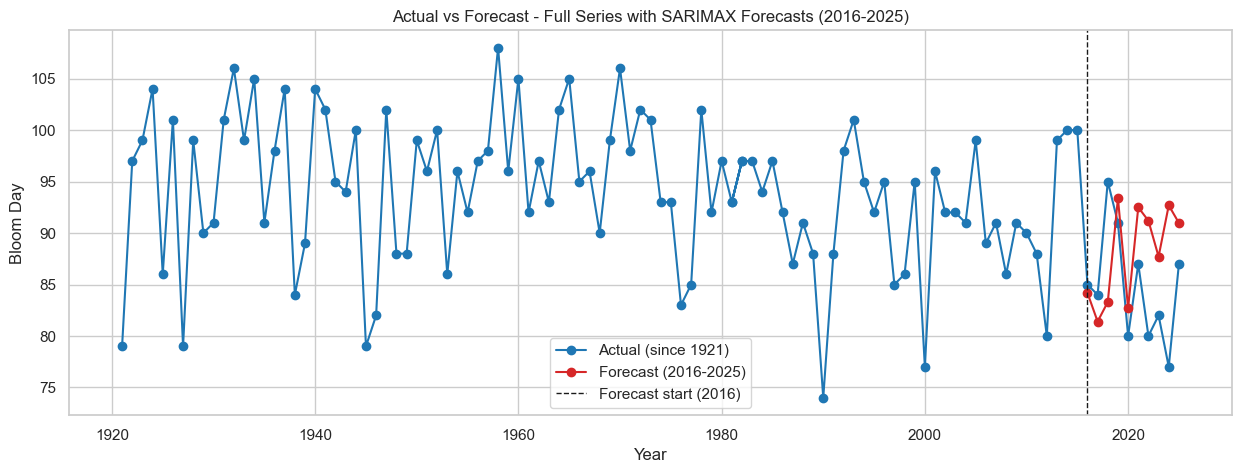

In [10]:
full_years = df['year']
full_actuals = df[TARGET]

plt.figure(figsize=(15, 5))
plt.plot(full_years, full_actuals.values, marker='o', color='tab:blue', label='Actual (since 1921)')

if len(test_df) > 0:
    plt.plot(test_df['year'], y_pred_test, marker='o', color='tab:red', label='Forecast (2016-2025)')
    plt.axvline(2016, color='k', linestyle='--', linewidth=1, label='Forecast start (2016)')

plt.xlabel('Year')
plt.ylabel('Bloom Day')
plt.title('Actual vs Forecast - Full Series with SARIMAX Forecasts (2016-2025)')
plt.legend()
plt.grid(True)
plt.show()


## 8) Notes and next steps

- We fit a SARIMAX model with exogenous predictors. The chosen order is simple (1,0,0); if you'd like, I can add automatic order selection (e.g., using pmdarima) or try a small grid search to find better ARIMA orders.
- Because we include exogenous regressors, the model leverages the same features used in the OLS model.
- Next steps: compare OLS vs SARIMAX predictions, add confidence intervals to forecasts, or try time-series cross-validation.
